# EDA
This notebook is to conduct exploratory data analysis for the Learning Agency Lab- PII Data Detect.


### Reference
1. https://www.kaggle.com/code/neslihanozeryildiz/creating-mini-data-sets-and-validation-data-set#Examining-Original-Data-Set

## Config and Import

In [1]:
from pathlib import Path
import os

import json
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings

Uncomment below if not running on kaggle

In [2]:
# !pip install kaggle -q

# import zipfile
# import kaggle
# from pathlib import Path

# # check if running on kaggle
# import os
# iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

# cred_path = Path('~/.kaggle/kaggle.json').expanduser()
# if not cred_path.exists():
#     cred_path.parent.mkdir(exist_ok=True)
#     creds = '{"username":"xxx","key":"xxx"}'  # Replace with your actual credentials
#     cred_path.write_text(creds)
#     cred_path.chmod(0o600)

# path = Path('pii-detection-removal-from-educational-data')

# if not iskaggle and not path.exists():
#     import zipfile,kaggle
#     kaggle.api.competition_download_cli(str(path))
#     zipfile.ZipFile(f'{path}.zip').extractall(path)

# Helper Functions

In [3]:
import matplotlib.pyplot as plt

def graph_label_compare(left_df, right_df, left_title, right_title):
    """
    Compare the label distributions of two DataFrames.

    Parameters:
    - left_df (DataFrame): First DataFrame to compare.
    - right_df (DataFrame): Second DataFrame to compare.
    - left_title (str): Title for the first DataFrame's plot.
    - right_title (str): Title for the second DataFrame's plot.
    """
    # Calculate the distribution of labels in the left DataFrame
    left_labels = left_df['labels'].explode()
    left_labels = left_labels[left_labels != 'O']  # Exclude 'O' labels
    left_label_distribution = left_labels.value_counts(normalize=True) * 100

    # Calculate the distribution of labels in the right DataFrame
    right_labels = right_df['labels'].explode()
    right_labels = right_labels[right_labels != 'O']  # Exclude 'O' labels
    right_label_distribution = right_labels.value_counts(normalize=True) * 100

    # Create the figure for the plots
    plt.figure(figsize=(10, 4))

    # Create a bar plot for the left DataFrame label distribution
    plt.subplot(1, 2, 1)
    left_label_distribution.plot(kind='bar', color='blue', alpha=0.5, label=left_title)
    for i in range(len(left_label_distribution)):
        plt.text(i, left_label_distribution.iloc[i] + 0.5, f"{left_label_distribution.iloc[i]:.2f}%", ha='center', va='bottom')
    plt.title(f'{left_title} Label Distribution')
    plt.xlabel('Labels')
    plt.ylabel('%')
    plt.legend()

    # Create a bar plot for the right DataFrame label distribution
    plt.subplot(1, 2, 2)
    right_label_distribution.plot(kind='bar', color='pink', alpha=0.5, label=right_title)
    for i in range(len(right_label_distribution)):
        plt.text(i, right_label_distribution.iloc[i] + 0.5, f"{right_label_distribution.iloc[i]:.2f}%", ha='center', va='bottom')
    plt.title(f'{right_title} Label Distribution')
    plt.xlabel('Labels')
    plt.ylabel('%')
    plt.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

# Meta Data
## Competition Dataset
Credit: https://www.kaggle.com/code/awsaf49/pii-data-detection-kerasnlp-starter-notebook#%F0%9F%A7%AE-|-Mixed-Precision 


The competition dataset comprises approximately 22,000 essays written by students enrolled in a massively open online course. All of the essays were written in response to a single assignment prompt, which asked students to apply course material to a real-world problem. The goal of the competition is to annotate personally identifiable information (PII) found within the essays.


In order to protect student privacy, the original PII in the dataset has been replaced by surrogate identifiers of the same type using a partially automated process. The competition dataset contains ~$22,000$ student essays where $70\%$ essays are reserved for **testing**, leaving $30\%$ for **training** and **validation**.

The modified markdown with an example of the BIO format label:

**Data Overview:**

* All essays were written in response to the **same prompt**, applying course material to a real-world problem.
* The dataset includes **7 types of PII**: `NAME_STUDENT`, `EMAIL`, `USERNAME`, `ID_NUM`, `PHONE_NUM`, `URL_PERSONAL`, `STREET_ADDRESS`.
* Labels are given in **BIO (Beginning, Inner, Outer)** format.

**Example of BIO format label:**

Let's consider a sentence: `"The email address of Michael jordan is mjordan@nba.com"`. In BIO format, the labels for the personally identifiable information (PII) would be annotated as follows:

| **Word** | The | email | address | of | Michael | Jordan | is | mjordan@nba.com |
|----------|-----|-------|---------|----|---------|--------|----|----------------|
| **Label** | O   | O     | O       | O  | B-NAME_STUDENT | I-NAME_STUDENT | O  | B-EMAIL        |

In the example above, `B-` indicates the beginning of an PII, `I-` indicates an inner part of a multi-token PII, and `O` indicates tokens that do not belong to any PII.

**Data Format:**

* The train/test data is stored in `{test|train}.json` files.
* Each json file has:
    * `document`: unique ID (integer)
    * `full_text`: essay content (string)
    * `tokens`: individual words in the essay (list of strings)
    * `labels` (training data only): BIO labels for each token (list of strings)

# Load Data

In [4]:
DATA_PATH = '../input/pii-detection-removal-from-educational-data'

#print files with pathname
for dirname, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input/pii-detection-removal-from-educational-data/sample_submission.csv
../input/pii-detection-removal-from-educational-data/train.json
../input/pii-detection-removal-from-educational-data/test.json


In [5]:
sample_submission = pd.read_csv(DATA_PATH +'/sample_submission.csv')
comp_train= json.load(open(DATA_PATH +'/train.json'))
comp_test= json.load(open(DATA_PATH + '/test.json'))


#Convert to df for EDA
ctest_df=pd.DataFrame(comp_test)
ctrain_df= pd.DataFrame(comp_train)
ctrain_df.head()

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


In [6]:
ctrain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6807 entries, 0 to 6806
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   document             6807 non-null   int64 
 1   full_text            6807 non-null   object
 2   tokens               6807 non-null   object
 3   trailing_whitespace  6807 non-null   object
 4   labels               6807 non-null   object
dtypes: int64(1), object(4)
memory usage: 266.0+ KB


In [7]:
#check if all expected labels represented
unique_labels_train = ctrain_df['labels'].explode().unique()
num_unique_labels_train = len(unique_labels_train)

print("Number of unique labels in competition train set:", num_unique_labels_train)
print("Unique labelsin competition train set:")
print(unique_labels_train)


Number of unique labels in competition train set: 13
Unique labelsin competition train set:
['O' 'B-NAME_STUDENT' 'I-NAME_STUDENT' 'B-URL_PERSONAL' 'B-EMAIL'
 'B-ID_NUM' 'I-URL_PERSONAL' 'B-USERNAME' 'B-PHONE_NUM' 'I-PHONE_NUM'
 'B-STREET_ADDRESS' 'I-STREET_ADDRESS' 'I-ID_NUM']


Expected to see 15. (B & I for all 7 PII types and 'O'). 
Missing:
- 'I-USERNAME'
- 'I-EMAIL'

In [8]:
#get breakdown of labels
#convert list of labels in each document to a set
label_sets= ctrain_df['labels'].apply(set)

#Set up dictionary to count occurances
label_count={}

for label_set in label_sets:
    #go through all entries in the set
    for label in label_set:
        #if label is in dictionary increment count
        if label in label_count:
            label_count[label]+=1
        #else add new label with count 1
        else:
            label_count[label] =1
            
#print label distribution
for label, count in label_count.items():
    print(f'docs with {label}: {count}')

docs with B-NAME_STUDENT: 891
docs with O: 6807
docs with I-NAME_STUDENT: 814
docs with B-URL_PERSONAL: 72
docs with B-EMAIL: 24
docs with B-ID_NUM: 33
docs with I-URL_PERSONAL: 1
docs with B-USERNAME: 5
docs with I-PHONE_NUM: 3
docs with B-PHONE_NUM: 4
docs with I-STREET_ADDRESS: 2
docs with B-STREET_ADDRESS: 2
docs with I-ID_NUM: 1


In [9]:
#Number of entries with only 'O'
only_o_count = ctrain_df['labels'].apply(lambda labels: any(label != 'O' for label in labels)).sum()
print("Number of Rows with only 'O': ", (ctrain_df.shape[0] - only_o_count))
print("Number of Rows with not only 'O': ", only_o_count)

Number of Rows with only 'O':  5862
Number of Rows with not only 'O':  945


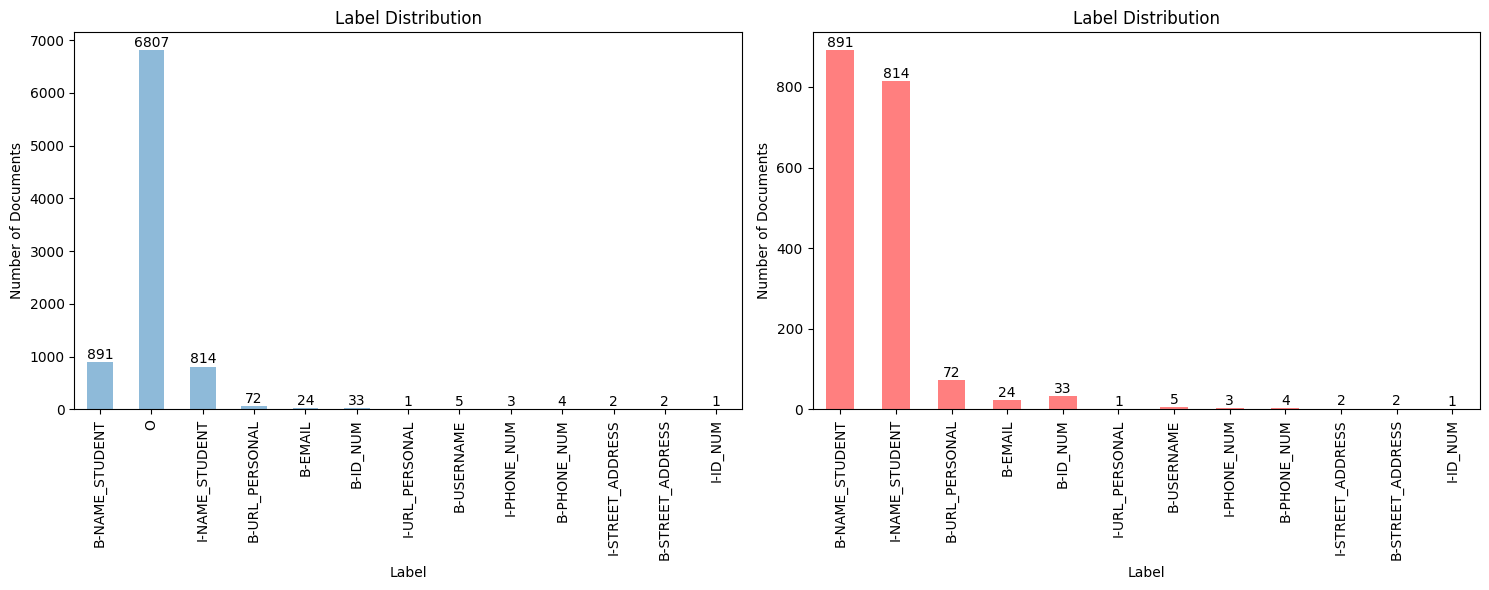

In [10]:
#plot distribution
# Convert the dictionary of label counts to a pandas Series for easier plotting
label_counts_series = pd.Series(label_count)
label_counts_series_no_O = label_counts_series.drop('O')


# plot next to each other 
plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
label_counts_series.plot(kind='bar', alpha =0.5)

# Set the title and labels
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Number of Documents')
for i in range(len(label_counts_series)):
    plt.text(i, label_counts_series.iloc[i] + 0.5, f"{label_counts_series.iloc[i]}", ha='center', va='bottom')
    
plt.subplot(1,2,2)
label_counts_series_no_O.plot(kind='bar', color='red', alpha =0.5)

# Set the title and labels
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Number of Documents')
for i in range(len(label_counts_series_no_O)):
    plt.text(i, label_counts_series_no_O.iloc[i] + 0.5, f"{label_counts_series_no_O.iloc[i]}", ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

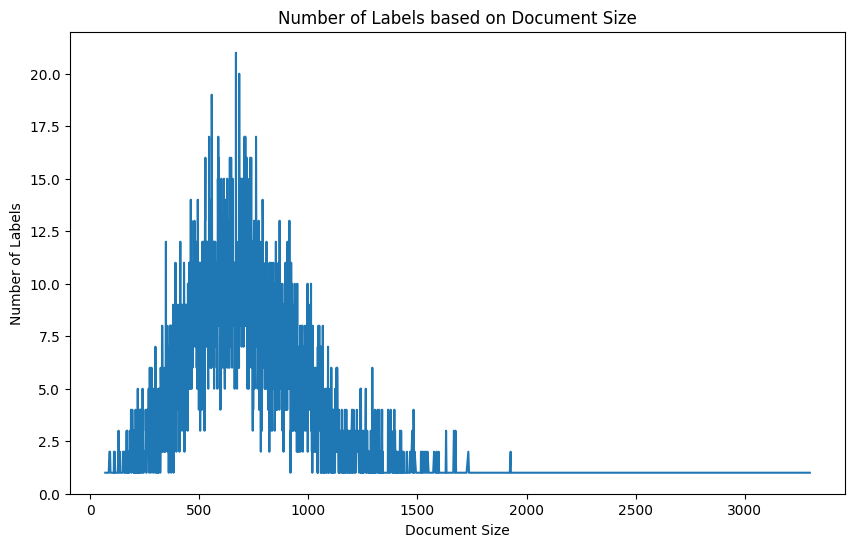

In [11]:
# Number of labels by document size
ctrain_df['doc_size'] = ctrain_df['tokens'].apply(len)

grouped = ctrain_df.groupby('doc_size')['labels'].count()

plt.figure(figsize=(10,6))
plt.plot(grouped.index, grouped.values)
plt.xlabel('Document Size')
plt.ylabel('Number of Labels')
plt.title('Number of Labels based on Document Size')
plt.show()

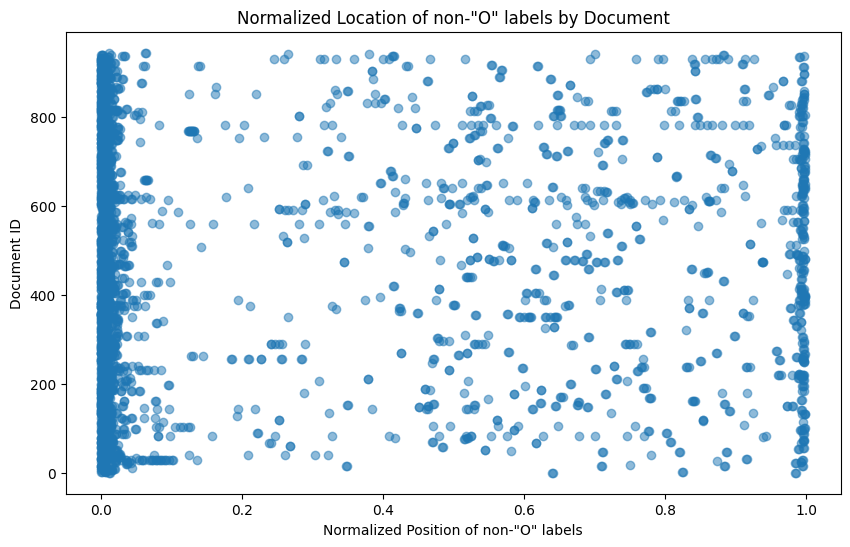

In [12]:
import numpy as np
import matplotlib.pyplot as plt

#drop docs that dont have entities
df_docs_with_entities = ctrain_df[ctrain_df['labels'].apply(lambda labels: not all(label == 'O' for label in labels))]

# Calculate normalized indices of non-"O" labels
normalized_non_o_indices = [[i/len(labels) for i, label in enumerate(labels) if label != 'O'] 
                            for labels in df_docs_with_entities['labels']]

# Convert to numpy arrays for efficient computation
doc_ids = np.repeat(np.arange(len(df_docs_with_entities)), [len(indices) for indices in normalized_non_o_indices])
normalized_indices = np.concatenate(normalized_non_o_indices)

# Plotting
plt.figure(figsize=(10,6))
plt.scatter(normalized_indices, doc_ids, alpha=0.5)  
plt.ylabel('Document ID')  
plt.xlabel('Normalized Position of non-"O" labels')
plt.title('Normalized Location of non-"O" labels by Document')
plt.show()

max doc_lengths_with_entities in tokens:  3298
max doc_lengths_all length in tokens:  3298


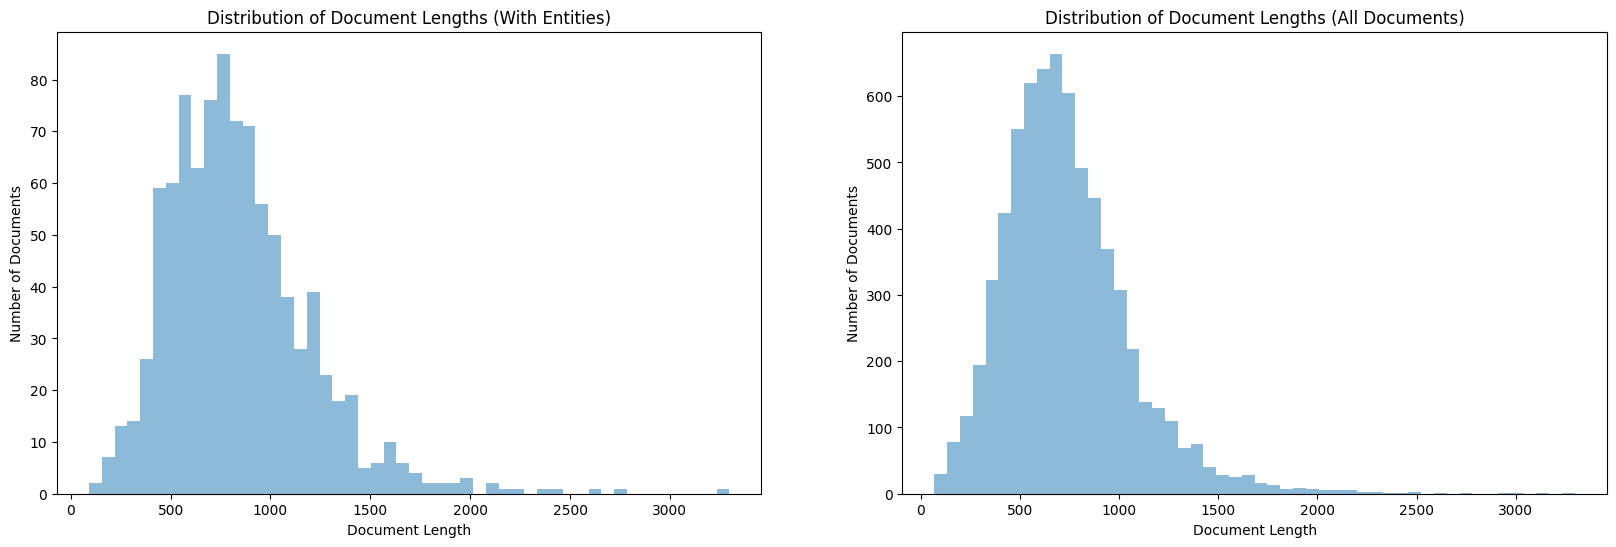

In [13]:
import numpy as np
import matplotlib.pyplot as plt

#drop docs that dont have entities
df_docs_with_entities = ctrain_df[ctrain_df['labels'].apply(lambda labels: not all(label == 'O' for label in labels))]

# Calculate document lengths
doc_lengths_with_entities = [len(labels) for labels in df_docs_with_entities['labels']]
doc_lengths_all = [len(labels) for labels in ctrain_df['labels']]

# Plotting
plt.figure(figsize=(20,6))

# Subplot for documents with entities
plt.subplot(1, 2, 1)
plt.hist(doc_lengths_with_entities, bins=50, alpha=0.5)
plt.xlabel('Document Length')
plt.ylabel('Number of Documents')
plt.title('Distribution of Document Lengths (With Entities)')

# Subplot for all documents
plt.subplot(1, 2, 2)
plt.hist(doc_lengths_all, bins=50, alpha=0.5)
plt.xlabel('Document Length')
plt.ylabel('Number of Documents')
plt.title('Distribution of Document Lengths (All Documents)')

print("max doc_lengths_with_entities in tokens: ", max(doc_lengths_with_entities))
print("max doc_lengths_all length in tokens: ", max(doc_lengths_all))
plt.show()